## 1- Bookmarks:
* https://www.youtube.com/watch?v=LhEMXbjGV_4
* https://pnqbrsdijjcpbadpnqtmbe.coursera-apps.org/notebooks/week2/KerasTutorial/Keras_Tutorial_v2a.ipynb#
* https://keras.io/preprocessing/image/
* https://colab.research.google.com/drive/1HzN2f0Mypj0r2rKJdKYCjczM1WzJyoaV
* https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

To divide images to train/valid/test sets:

In [50]:
import numpy as np
import pandas as pd
import itertools
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
from keras import optimizers
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications import VGG19
#from keras.applications.imagenet_utils import preprocess_input
#import pydot
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from kt_utils import *

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils.np_utils import to_categorical
import os
import datetime
import math

#import tensorflow as tf
%matplotlib inline

In [2]:
#Graphing our training and validation
def plotTraining(history):
    acc = history.history["acc"]
    val_acc = history.history["val_acc"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(acc))
    plt.plot(epochs, acc, "r", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.ylabel("accuracy") 
    plt.xlabel("epoch")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.ylabel("loss") 
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

In [3]:
image_size_h = 382
image_size_w = 512
train_batch_size = 64
dev_batch_size = 64
test_batch_size = 64
epochs = 100

train_path = "C:\\Users\\Sean\\Downloads\\cs230_jupyter\\VMMRdb_mini\\train"
dev_path = 'C:\\Users\\Sean\\Downloads\\cs230_jupyter\\VMMRdb_mini\\dev'
test_path = 'C:\\Users\\Sean\\Downloads\\cs230_jupyter\\VMMRdb_mini\\test'

bottleneck_file_root = "D:\\Debian\\cs_230_proj\\bottleneck\\"
top_model_weights_path = "bottleneck_fc_model.h5"


In [51]:
##################################
##NO NEED TO RUN EVERY SINGLE TIME
##################################
vgg = VGG19(include_top=False, weights="imagenet",input_shape=(image_size_w, image_size_h, 3))

#To pop last few layers
vgg.layers.pop()
vgg.layers.pop()
vgg.layers.pop()
vgg.layers.pop()
vgg.layers.pop()


#TRAIN SET
datagen_train = ImageDataGenerator(rescale=1. / 255) 
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator_train = datagen_train.flow_from_directory( 
    train_path, 
    target_size=(image_size_w, image_size_h), 
    batch_size=train_batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator_train.filenames) 
num_classes = len(generator_train.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / train_batch_size)) 
 
bottleneck_features_train = vgg.predict_generator(generator_train, predict_size_train) 
 
np.save(bottleneck_file_root+"bottleneck_features_train.npy", bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)

#DEV SET
start = datetime.datetime.now()
datagen_dev = ImageDataGenerator(rescale=1. / 255) 

generator_dev = datagen_dev.flow_from_directory( 
    dev_path, 
    target_size=(image_size_w, image_size_h), 
    batch_size=dev_batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_dev_samples = len(generator_dev.filenames) 
num_classes = len(generator_dev.class_indices) 
 
predict_size_dev = int(math.ceil(nb_dev_samples / dev_batch_size)) 
 
bottleneck_features_dev = vgg.predict_generator(generator_dev, predict_size_dev) 
 
np.save(bottleneck_file_root+"bottleneck_features_dev.npy", bottleneck_features_dev)
end = datetime.datetime.now()
print("Time: ", end-start)
#TEST SET
start = datetime.datetime.now()

datagen_test = ImageDataGenerator(rescale=1. / 255) 

generator_test = datagen_test.flow_from_directory( 
    test_path, 
    target_size=(image_size_w, image_size_h), 
    batch_size=test_batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_test_samples = len(generator_test.filenames) 
num_classes_ = len(generator_test.class_indices) 
 
predict_size_test = int(math.ceil(nb_test_samples / test_batch_size)) 
 
bottleneck_features_test = vgg.predict_generator(generator_test, predict_size_test) 
 
np.save(bottleneck_file_root+"bottleneck_features_test.npy", bottleneck_features_test)
end = datetime.datetime.now()
print("Time: ", end-start)


Found 2555 images belonging to 6 classes.
Time:  0:00:22.254723
Found 320 images belonging to 6 classes.
Time:  0:00:03.084291
Found 317 images belonging to 6 classes.
Time:  0:00:03.099266


In [92]:
#training data
generator_top = datagen_train.flow_from_directory( 
   train_path, 
   target_size=(image_size_w, image_size_h), 
   batch_size=train_batch_size, 
   class_mode="categorical", 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load(bottleneck_file_root+"bottleneck_features_train.npy") 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

#validation data
generator_top_dev = datagen_dev.flow_from_directory( 
   dev_path, 
   target_size=(image_size_w, image_size_h), 
   batch_size=dev_batch_size, 
   class_mode="categorical", 
   shuffle=False) 
 
nb_dev_samples = len(generator_top_dev.filenames) 
num_classes_dev = len(generator_top_dev.class_indices) 
 
# load the bottleneck features saved earlier 
dev_data = np.load(bottleneck_file_root+"bottleneck_features_dev.npy") 
 
dev_labels = generator_top_dev.classes 
 
dev_labels = to_categorical(dev_labels, num_classes=num_classes_dev)

#test data
generator_top_test = datagen_test.flow_from_directory( 
   test_path, 
   target_size=(image_size_w, image_size_h), 
   batch_size=test_batch_size, 
   class_mode="categorical", 
   shuffle=False) 
 
nb_test_samples = len(generator_top_test.filenames) 
num_classes_test = len(generator_top_test.class_indices) 
 
# load the bottleneck features saved earlier 
test_data = np.load(bottleneck_file_root+"bottleneck_features_test.npy") 
 
test_labels = generator_top_test.classes 
 
test_labels = to_categorical(test_labels, num_classes=num_classes_test)


Found 2555 images belonging to 6 classes.
Found 320 images belonging to 6 classes.
Found 317 images belonging to 6 classes.


In [185]:
print(train_data.shape[1:])
vgg.summary()

(16, 11, 512)
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 512, 382, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 382, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 382, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 191, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 191, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 191, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 95, 12

In [174]:
# #freeze less layers to be trained
# for layer in vgg.layers[:-4]:
#     layer.trainable = False
# for layer in vgg.layers:
#     print(layer.name, layer.trainable)

input_14 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 False
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True


In [93]:
start = datetime.datetime.now()
model = Sequential() 

#adding back poped 4 conv + 1 pool layer
print(train_data.shape[1:])
model.add(ZeroPadding2D((1,1),input_shape=train_data.shape[1:]))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

#FC layers
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.5)) 
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.3))
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation="softmax"))

model.compile(loss="categorical_crossentropy",
   optimizer=optimizers.Adam(lr=0.5e-4),#optimizers.RMSprop(lr=1e-4),
   metrics=["acc"])

#To use npy input
history = model.fit(train_data, train_labels, 
   epochs=100,
   batch_size=train_batch_size, 
   validation_data=(dev_data, dev_labels))

model.save_weights(top_model_weights_path)

(eval_loss, eval_accuracy) = model.evaluate( 
    dev_data, dev_labels, batch_size=dev_batch_size,verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 

end= datetime.datetime.now()
elapsed= end-start
print ("Time: ", elapsed)



(16, 11, 512)
Train on 2555 samples, validate on 320 samples
Epoch 1/100
2555/2555 [==============================] - 2s 842us/step - loss: 1.7453 - acc: 0.2626 - val_loss: 1.6572 - val_acc: 0.2750
Epoch 2/100
2555/2555 [==============================] - 2s 754us/step - loss: 1.4653 - acc: 0.4204 - val_loss: 1.1698 - val_acc: 0.5562
Epoch 3/100
2555/2555 [==============================] - 2s 760us/step - loss: 1.0197 - acc: 0.6067 - val_loss: 0.7467 - val_acc: 0.7063
Epoch 4/100
2555/2555 [==============================] - 2s 756us/step - loss: 0.7285 - acc: 0.7252 - val_loss: 0.5319 - val_acc: 0.8031
Epoch 5/100
2555/2555 [==============================] - 2s 753us/step - loss: 0.4848 - acc: 0.8282 - val_loss: 0.3752 - val_acc: 0.8594
Epoch 6/100
2555/2555 [==============================] - 2s 756us/step - loss: 0.4143 - acc: 0.8595 - val_loss: 0.5934 - val_acc: 0.7594
Epoch 7/100
2555/2555 [==============================] - 2s 760us/step - loss: 0.3270 - acc: 0.8908 - val_loss: 0.265

Epoch 60/100
2555/2555 [==============================] - 2s 751us/step - loss: 0.0051 - acc: 0.9984 - val_loss: 0.2101 - val_acc: 0.9594
Epoch 61/100
2555/2555 [==============================] - 2s 758us/step - loss: 0.0034 - acc: 0.9992 - val_loss: 0.2164 - val_acc: 0.9531
Epoch 62/100
2555/2555 [==============================] - 2s 755us/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.2198 - val_acc: 0.9531
Epoch 63/100
2555/2555 [==============================] - 2s 755us/step - loss: 3.1689e-04 - acc: 1.0000 - val_loss: 0.2113 - val_acc: 0.9563
Epoch 64/100
2555/2555 [==============================] - 2s 751us/step - loss: 8.0459e-04 - acc: 1.0000 - val_loss: 0.2068 - val_acc: 0.9563
Epoch 65/100
2555/2555 [==============================] - 2s 756us/step - loss: 1.7311e-04 - acc: 1.0000 - val_loss: 0.2154 - val_acc: 0.9594
Epoch 66/100
2555/2555 [==============================] - 2s 760us/step - loss: 1.4058e-04 - acc: 1.0000 - val_loss: 0.2159 - val_acc: 0.9531
Epoch 67/100
2555/

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 18, 13, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 11, 512)       2359808   
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 18, 13, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 11, 512)       2359808   
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 18, 13, 512)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 11, 512)       2359808   
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 18, 13, 512)      

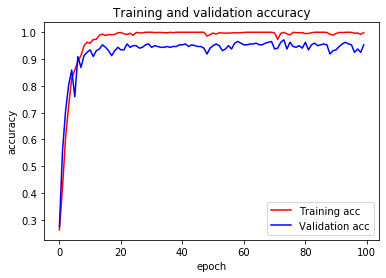

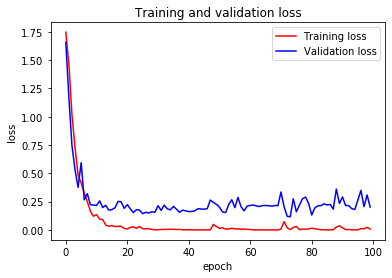

['loss', 'acc']
317/317 [==============================] - 0s 450us/step


[0.25040069569125534, 0.9369085431098938]

In [94]:
plotTraining(history)
print(model.metrics_names)
model.evaluate(test_data,test_labels)


In [95]:
model.evaluate(test_data,test_labels)
preds = np.round(model.predict(test_data),0)
print('rounded test_labels',preds)
classesList = os.listdir(train_path)
classification_metrics = metrics.classification_report(test_labels,preds,target_names=classesList)
print(classification_metrics)

317/317 [==============================] - 0s 450us/step
rounded test_labels [[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]]
                          precision    recall  f1-score   support

chevrolet_silverado_2004       0.96      0.98      0.97        48
      ford_explorer_2002       0.95      0.98      0.96        88
        honda_civic_2002       0.89      0.92      0.91        53
      nissan_altima_2006       0.91      0.95      0.93        42
       toyota_camry_2007       1.00      0.85      0.92        46
   volkswagen_jetta_2006       0.95      0.90      0.92        40

               micro avg       0.94      0.94      0.94       317
               macro avg       0.94      0.93      0.93       317
            weighted avg       0.94      0.94      0.94       317
             samples avg       0.94      0.94      0.94       317



d:\anaconda3\envs\keras-gpu\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [68]:
#categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
#categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
#test_pred = np.argmax(preds, axis=1)

#print(np.argmax(test_labels,axis=1))
#print(test_pred)


#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm1, classes,
   normalize=False,
   title="Confusion matrix",
   cmap=plt.cm.Blues):
 
#Add Normalization Option
#  prints pretty confusion metric with normalization option 
   if normalize:
     cm = cm1.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
     print("Normalized confusion matrix")
   else:
     print("Confusion matrix, without normalization")
 
# print(cm)
 
   plt.imshow(cm, interpolation='nearest', cmap=cmap)
   plt.title(title)
   plt.colorbar()
   tick_marks = np.arange(len(classes))
   plt.xticks(tick_marks, classes, rotation=45)
   plt.yticks(tick_marks, classes)
 
   fmt = ".2f" if normalize else "d"
   thresh = cm.max() / 2.
   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
   plt.tight_layout()
   plt.ylabel("True label")
   plt.xlabel("Predicted label") 

Normalized confusion matrix


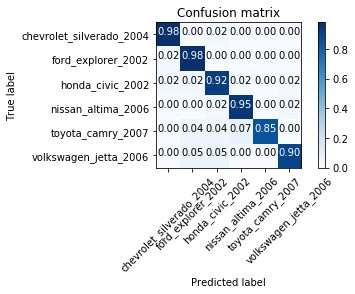

In [96]:
cm2 = confusion_matrix(np.argmax(test_labels,axis=1).tolist(), np.argmax(preds, axis=1).tolist())

plot_confusion_matrix(cm2,
                     classesList,
                     normalize=True)

=====Below code is not yet working=====

In [ ]:

# classesList = os.listdir(train_path)
# print(classesList)
# class_size = len(classesList)
# # datagen = ImageDataGenerator(rescale=1./255)
# # generator = datagen.flow_from_directory(
# #     train_path,
# #     target_size=(image_size_h, image_size_w), 
# #     #classes=classesList, 
# #     class_mode=None,
# #     batch_size=train_batch_size
# #     #color_mode='grayscale'
# # )



# train_batches = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     vertical_flip=True,
#     fill_mode='nearest'
# ).flow_from_directory(
#     train_path, 
#     target_size=(image_size_h, image_size_w), 
#     classes=classesList, 
#     batch_size=train_batch_size
#     #color_mode='grayscale'
# )

# dev_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(
#     dev_path, 
#     target_size=(image_size_h, image_size_w), 
#     classes=classesList, 
#     batch_size=dev_batch_size
#     #color_mode='grayscale'
# #     class_mode=None
# )

# test_batches = ImageDataGenerator().flow_from_directory(
#     test_path, 
#     target_size=(image_size_h, image_size_w), 
#     #classes=classesList, 
#     batch_size=test_batch_size
#    # color_mode='grayscale'
# )




In [ ]:
# #source: https://github.com/smileservices/keras_utils/blob/master/utils.py
# # plots images with labels within jupyter notebook
# def plots(ims, figsize=(60,30), rows=2, interp=False, titles=None):
#     if type(ims[0]) is np.ndarray:
#         ims = np.array(ims).astype(np.uint8)
#         if (ims.shape[-1] != 3):
#             ims = ims.transpose((0,2,3,1))
#     f = plt.figure(figsize=figsize)
#     cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
#     for i in range(len(ims)):
#         sp = f.add_subplot(rows, cols, i+1)
#         sp.axis('Off')
#         if titles is not None:
#             sp.set_title(titles[i], fontsize=16)
#         plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
# imgs,labels= next(train_batches)

In [ ]:
# print(imgs.shape)
# plots(imgs,titles=labels)

In [ ]:
# #Load the VGG model
# vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size_h, image_size_w, 3))

# for layer in vgg_conv.layers[:-4]:
#     layer.trainable = False
# for layer in vgg_conv.layers:
#     print(layer)

# # model =Sequential([
# #     Conv2D(32,(3,3),activation='relu',input_shape=(382,512,3)),
# #     Flatten(),
# #     Dense(8,activation='softmax'),
# # ])
# # model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

# # model.fit_generator(train_batches, steps_per_epoch=34,validation_data=dev_batches, validation_steps=4, epochs = 5, verbose = 2)


In [72]:
# #define the model
# model= Sequential([
#     vgg_conv,
#     Flatten(),
#     Dense(512,activation='relu'),
#     Dropout(0.8),
#     Dense(class_size, activation='softmax')
# ])
# model.summary()

# optimizer = optimizers.Adam()#lr=0.001)


In [85]:
#funtion to display correctly or incorrectly predicted pictures
def display_images(set,path):
    # Show the set
    for i in range(len(set)):
        pred_class = np.argmax(predictions[set[i]])
        pred_label = idx2label[pred_class]

        title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
            fnames[set[i]].split('/')[0],
            pred_label,
            predictions[set[i]][pred_class])

        original = load_img('{}/{}'.format(path,fnames[set[i]]))
        plt.figure(figsize=[7,7])
        plt.axis('off')
        plt.title(title)
        plt.imshow(original)
        plt.show()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 16, 11, 512)       10585152  
_________________________________________________________________
sequential_11 (Sequential)   (None, 6)                 14716038  
Total params: 25,301,190
Trainable params: 25,301,190
Non-trainable params: 0
_________________________________________________________________
None
Found 317 images belonging to 6 classes.
5/5 [==============================] - 3s 544ms/step
No of errors = 20/317


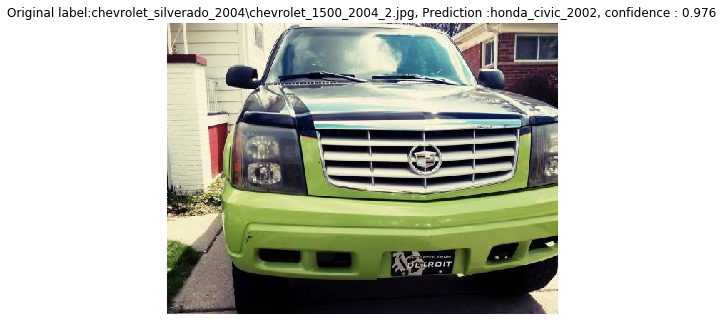

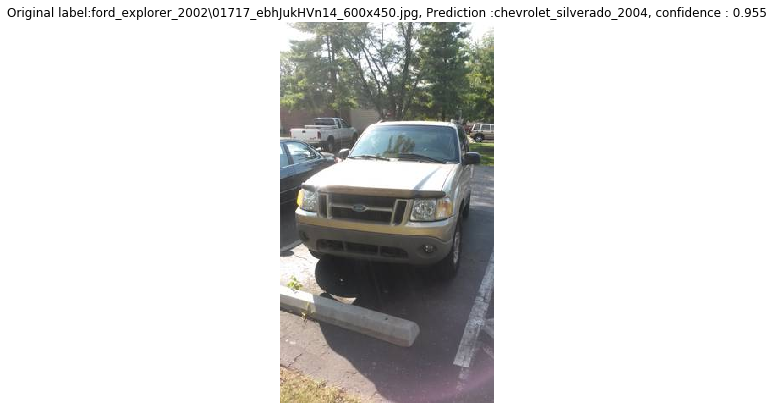

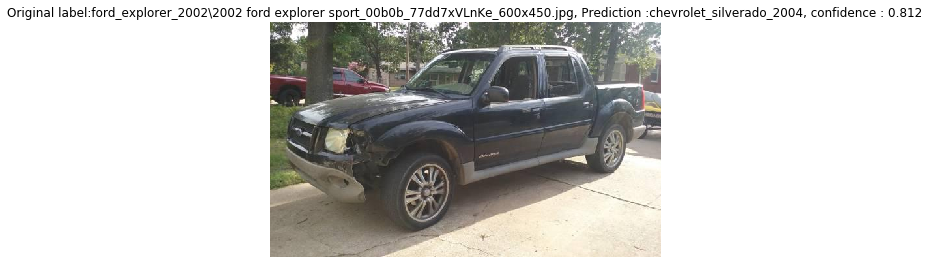

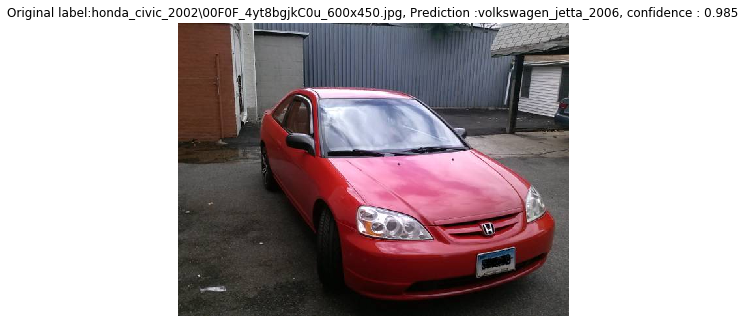

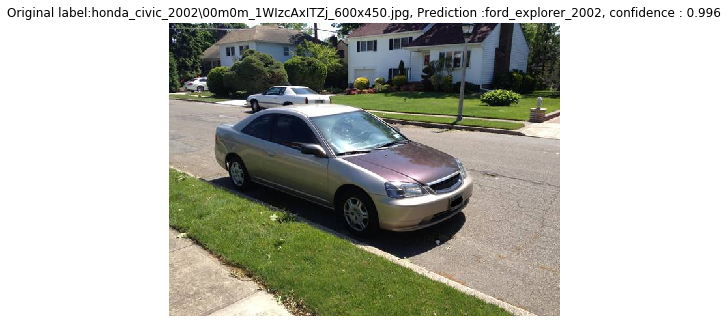

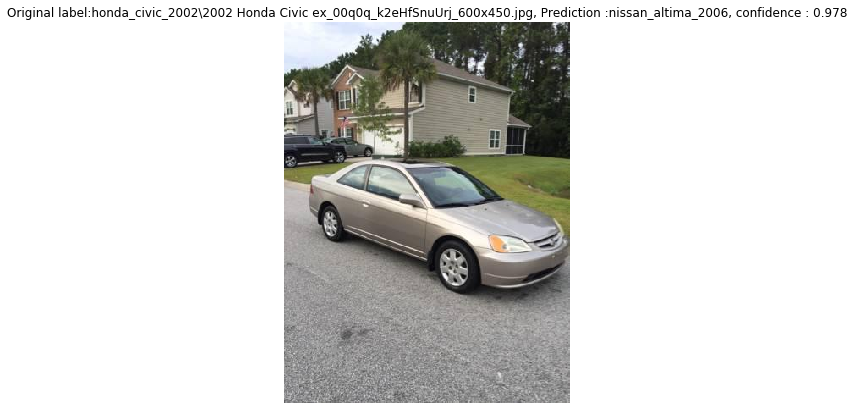

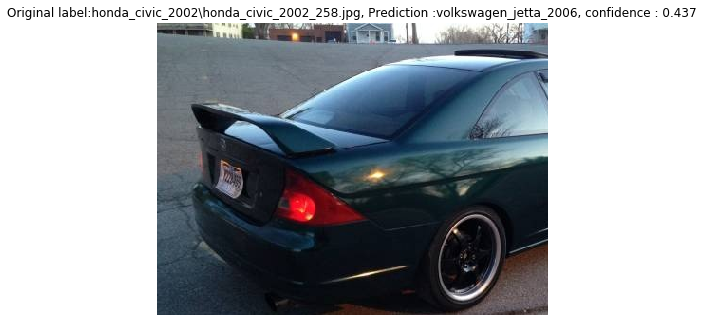

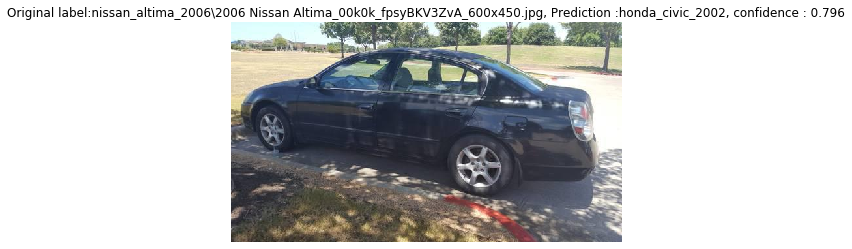

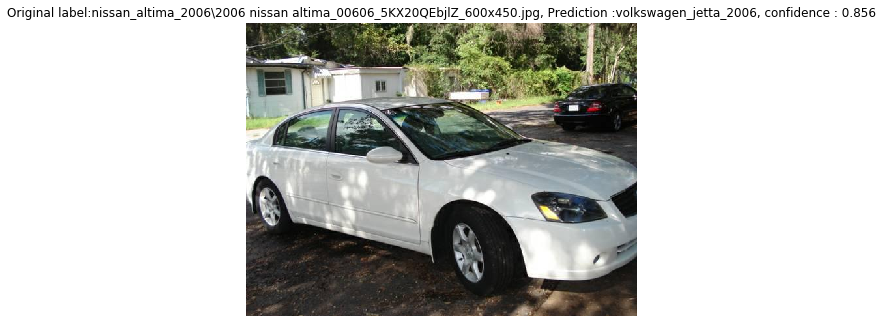

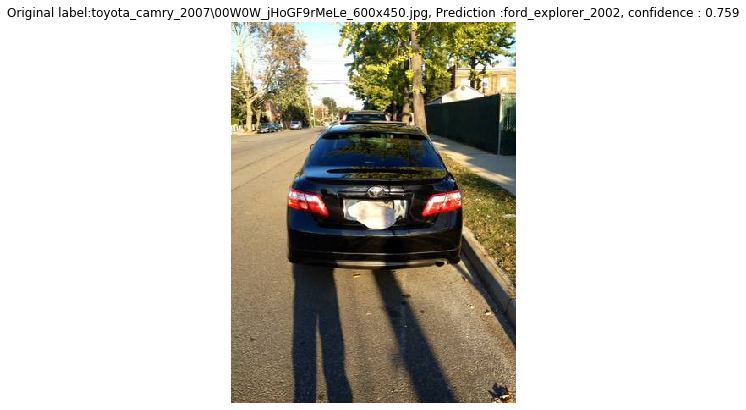

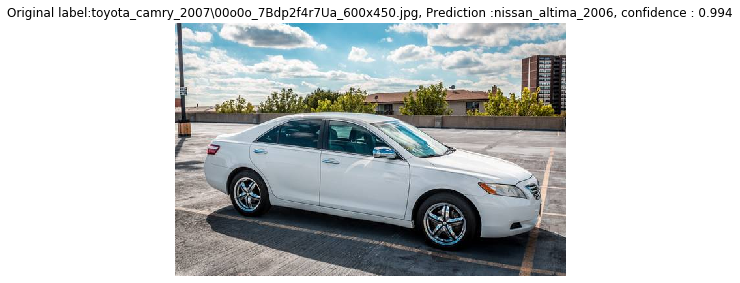

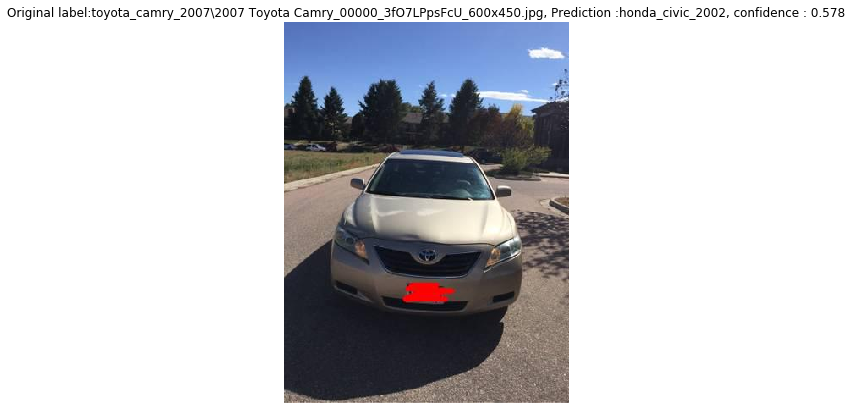

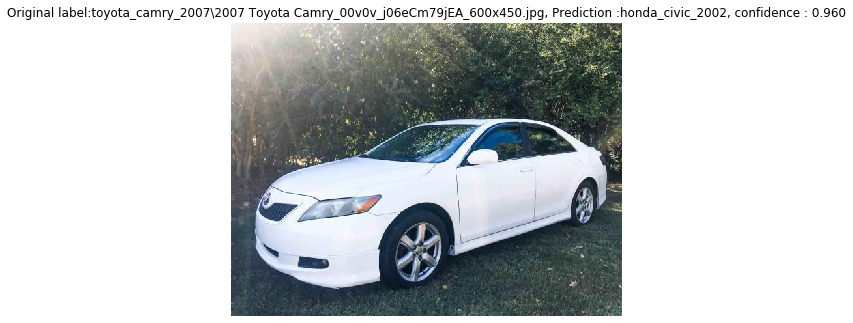

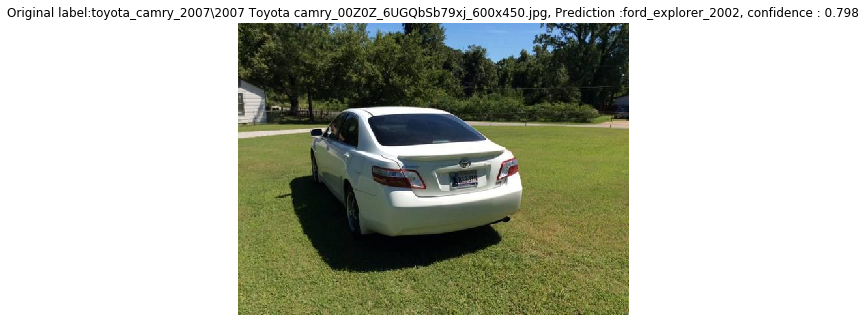

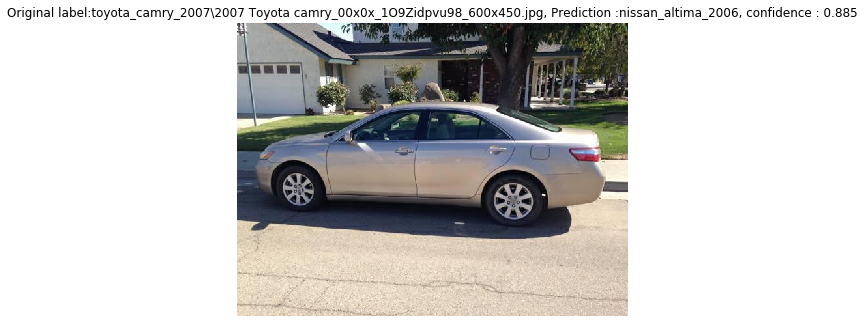

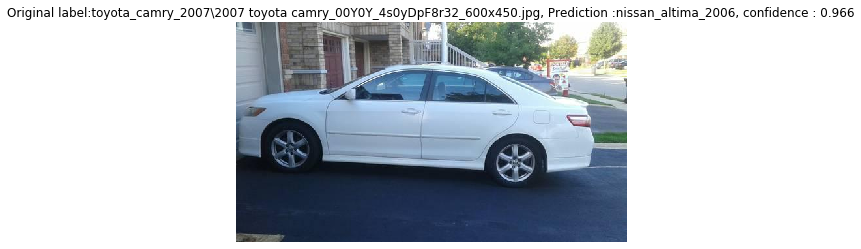

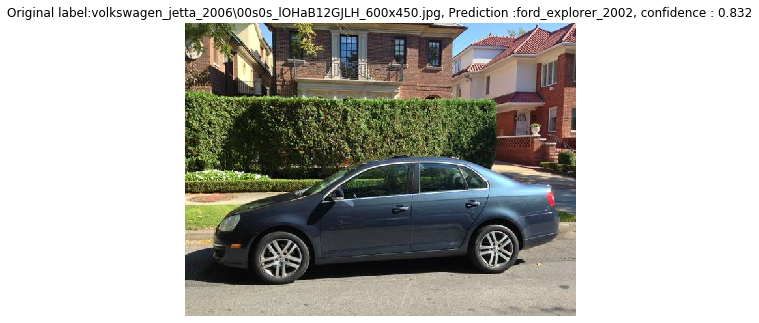

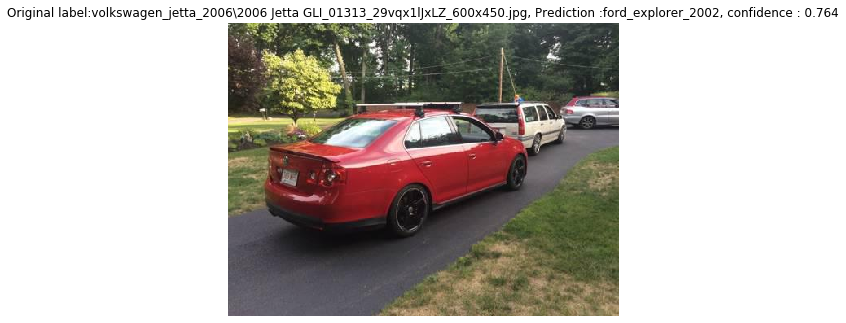

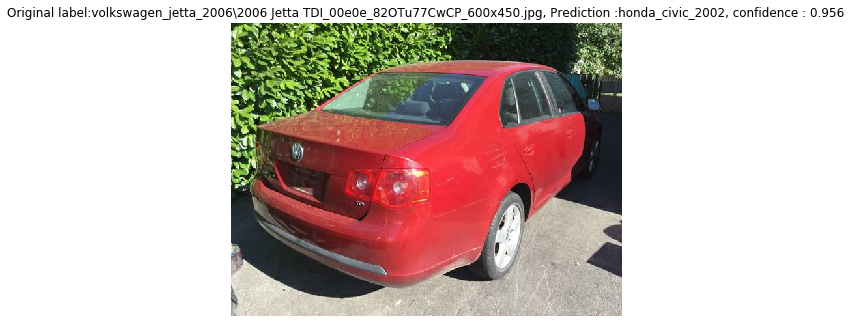

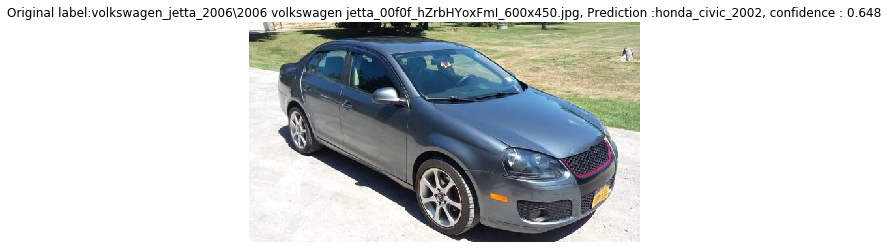

In [99]:
# #form the final full model 
# output = model(vgg.outputs)
# full_model = Model(vgg.inputs, output)

full_model = Sequential()
full_model.add(vgg)
full_model.add(model)


# print("VGG1111")
# print(vgg.summary())
# print("model22222")
# print(model.summary())
# print("3333")
print(full_model.summary())

# Create a generator for prediction
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(image_size_w, image_size_h),
        batch_size=test_batch_size,
        class_mode='categorical',
        shuffle=False)

 
# Get the filenames from the generator
fnames = test_generator.filenames
 
# Get the ground truth from generator
ground_truth = test_generator.classes
 
# Get the label to class mapping from the generator
label2index = test_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())   


# Get the predictions from the model using the generator
predictions = full_model.predict_generator(test_generator, steps=predict_size_test,verbose=1)
predicted_classes = np.argmax(predictions,axis=1)    
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))
 
corrects = np.where(predicted_classes == ground_truth)[0]

display_images(errors,test_path)

